## Data preparation and visualization
The dataset must be prepared according to the following steps:

In [196]:
# Remove warnings from output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
from matplotlib.colors import ListedColormap, Normalize

# Load power dataset
building_data_train = pd.read_csv("data/building_4_weather_1_train.csv", parse_dates=["timestamp"], index_col=["timestamp"])
building_data_test = pd.read_csv("data/building_4_weather_1_test.csv", parse_dates=["timestamp"], index_col=["timestamp"])

# merge train and test data
building_data_merge = pd.concat([building_data_train, building_data_test])

# Load weather dataset
weather_data = pd.read_csv("data/weather_1.csv", parse_dates=["timestamp"], index_col=["timestamp"])

**1.1** Merge the different data sources (i.e. building consumption and weather) for both training and testing.

In [197]:
# Check for duplicate timestamps
print(f"Num of duplicated \"timestamp\" in weather_data: {weather_data.index.duplicated().sum()}")
print(f"Duplicated \"timestamp\" in weather_data:\n{weather_data[weather_data.index.duplicated()]}")
print()
print(f"Num of duplicated \"timestamp\" in building_data_merge: {building_data_merge.index.duplicated().sum()}")
print()

# There are:
# 1 duplicated "timestamp" in weather_data
# 0 duplicated "timestamp" in building_data_train

# Remove duplicated timestamps
weather_data = weather_data[~weather_data.index.duplicated()]

Num of duplicated "timestamp" in weather_data: 1
Duplicated "timestamp" in weather_data:
                     airTemperature
timestamp                          
2017-10-29 02:00:00            12.8

Num of duplicated "timestamp" in building_data_merge: 0



In [198]:
# Check for missing timestamps
missing_timestamps_weather = pd.date_range(start=weather_data.index.min(), end=weather_data.index.max(), freq="H")
missing_timestamps_weather = missing_timestamps_weather.difference(weather_data.index)
print(f"Missing \"timestamp\" in weather_data:\n {missing_timestamps_weather}")
print()
missing_timestamps_building = pd.date_range(start=building_data_merge.index.min(), end=building_data_merge.index.max(), freq="H")
missing_timestamps_building = missing_timestamps_building.difference(building_data_merge.index)
print(f"Missing \"timestamp\" in building_data_train:\n {missing_timestamps_building}")
print()

# There are:
# 1 missing "timestamp" in weather_data
# 0 missing "timestamp" in building_data_train

# Fill missing timestamps
weather_data = weather_data.asfreq('H',method='ffill')

Missing "timestamp" in weather_data:
 DatetimeIndex(['2017-03-26 02:00:00'], dtype='datetime64[ns]', freq=None)

Missing "timestamp" in building_data_train:
 DatetimeIndex([], dtype='datetime64[ns]', freq='H')



In [199]:
# Now that we know that the index ("timestamp") are fixed we can merge the datasets

# Merge the energy and temperature datasets
data = building_data_merge.join(weather_data, how='inner')

**1.2** _Identification of statistical outliers_: statistical outliers should be identified (if they exists) according to one of the methods analyzed during the course and removed for both the training and testing dataset.

Number of outliers detected with Z-score method: 86


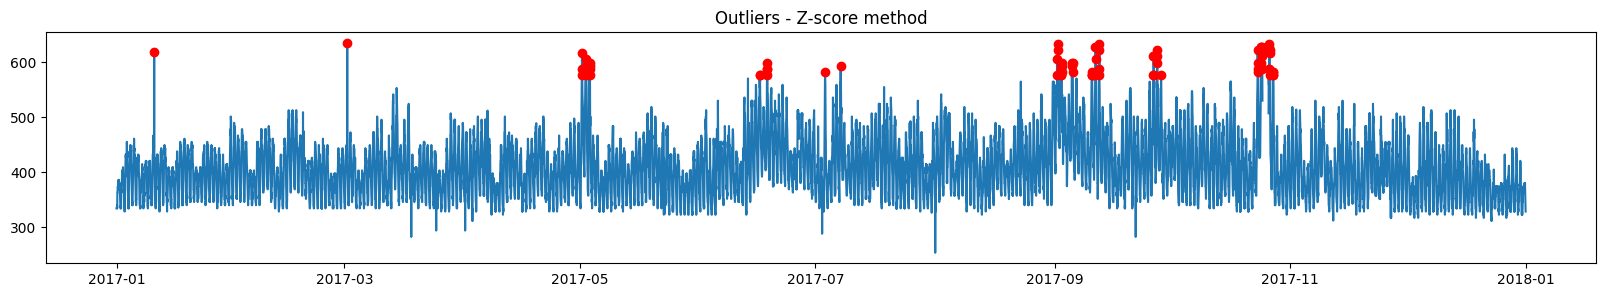

In [200]:
# Outlier detection: Z-score method

z_scores = (data['power'] - data['power'].mean()) / data['power'].std()
std_limit = 3
outliers_z_score = data['power'][(z_scores > std_limit) | (z_scores < -std_limit)]

print(f"Number of outliers detected with Z-score method: {len(outliers_z_score)}")

fig, ax = plt.subplots(figsize=(20, 3))
ax.set_title("Outliers - Z-score method")
# ax.set_label(f"Count {len(outliers_z_score)}")
ax.plot(data['power'])
ax.plot(outliers_z_score.index, data.loc[outliers_z_score.index, 'power'], 'ro')

Number of outliers detected with interquartile method: 93


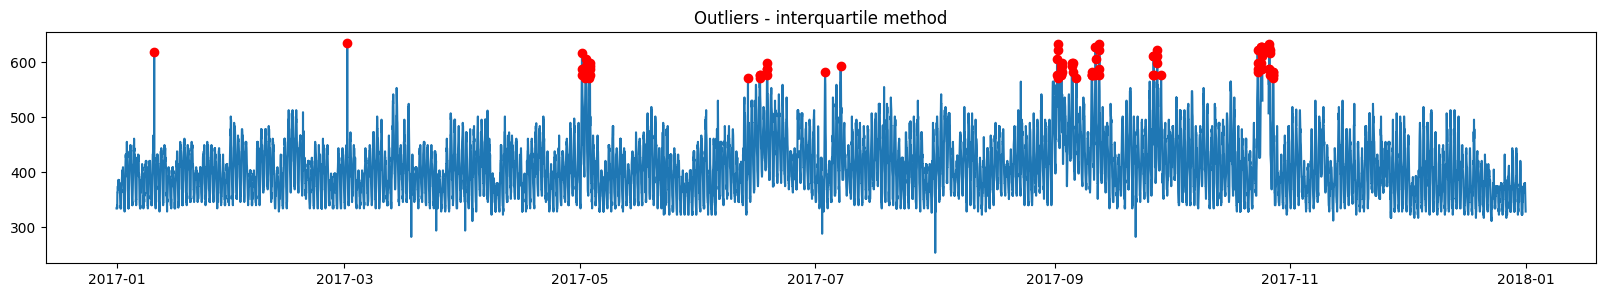

In [201]:
# Outlier detection: interquartile (or boxplot) method

Q1 = data['power'].quantile(0.25)
Q3 = data['power'].quantile(0.75)
IQR = Q3 - Q1
IQR_limit = 1.5

outliers_interquartile = data['power'][(data['power'] < Q1 - IQR_limit*IQR) | (data['power'] > Q3 + IQR_limit*IQR)]

print(f"Number of outliers detected with interquartile method: {len(outliers_interquartile)}")

fig, ax = plt.subplots(figsize=(20, 3))
ax.set_title("Outliers - interquartile method")
# ax.set_label(f"Count {len(outliers_interquartile)}")
ax.plot(data['power'])
ax.plot(outliers_interquartile.index, data.loc[outliers_interquartile.index, 'power'], 'ro')

In [202]:
# # TODO: Outlier deletion

# def replace_outliers_na(data, column, multiplier=1.5):
#     # Calculate the first and third quartiles (Q1 and Q3)
#     Q1 = data[column].quantile(0.25)
#     Q3 = data[column].quantile(0.75)
    
#     # Calculate the IQR
#     IQR = Q3 - Q1
    
#     # Calculate the lower and upper bounds for outliers
#     lower_bound = Q1 - multiplier * IQR
#     upper_bound = Q3 + multiplier * IQR
    
#     # Filter the dataset to remove the outliers
#     mask = (data[column] < lower_bound) | (data[column] > upper_bound)
#     data.loc[mask, column] = np.nan

#     return data

# data = replace_outliers_na(data.copy(), 'power')


**1.3** _Missing values replacement_: missing values should be replaced according to one of the methods analyzed during the course for both training and testing set. Pay attention to not abuse of replacement methods. Avoid filling gaps larger than 3 timesteps.

In [203]:
# Check for null values of "power" and "airTemperature"
print(f"Num of null \"airTemperature\" data: {data['airTemperature'].isna().sum()}")
print()
print(f"Num of null \"power\" data: {data['power'].isna().sum()}")
data[data['power'].isna()]

# There are:
# 0 null "airTemperature" data
# 46 null "power" data

Num of null "airTemperature" data: 0

Num of null "power" data: 46


,power,airTemperature
timestamp,,
2017-03-12 02:00:00,NaN,10.6
2017-06-26 20:00:00,NaN,17.8
2017-09-01 16:00:00,NaN,36.7
2017-09-01 17:00:00,NaN,35.0
2017-09-01 18:00:00,NaN,32.2
2017-09-05 11:00:00,NaN,25.6
2017-09-05 12:00:00,NaN,26.7
2017-09-05 13:00:00,NaN,26.7
2017-10-08 14:00:00,NaN,25.0


In [204]:
# In this type of problem, when there is a NaN hole for 4/6/8 hours
# it is BETTER TO ELIMINATE THE DATA THAN INTERPOLATE.

# Delete the NaN "big" holes (2017-10-24, 2017-10-25, 2017-10-26)
data = data[ (data.index < "2017-10-24 00:00:00") | (data.index > "2017-10-26 23:59:00")]
print(f"Num of missing values in building_data_merge: {data['power'].isna().sum()}")
data[data['power'].isna()]

Num of missing values in building_data_merge: 9


,power,airTemperature
timestamp,,
2017-03-12 02:00:00,NaN,10.6
2017-06-26 20:00:00,NaN,17.8
2017-09-01 16:00:00,NaN,36.7
2017-09-01 17:00:00,NaN,35.0
2017-09-01 18:00:00,NaN,32.2
2017-09-05 11:00:00,NaN,25.6
2017-09-05 12:00:00,NaN,26.7
2017-09-05 13:00:00,NaN,26.7
2017-10-08 14:00:00,NaN,25.0


In [205]:
# Fill NaN "small" holes (max 3 hours in a row)
data['power'].interpolate(method='spline', limit=3, inplace=True, order=3)

print(f"Num of missing values in building_data_merge: {data['power'].isna().sum()}")

Num of missing values in building_data_merge: 0


**1.4** _Data visualization_: describe the time series data through different visualization techniques. Take inspiration from the different examples introduced during the course.

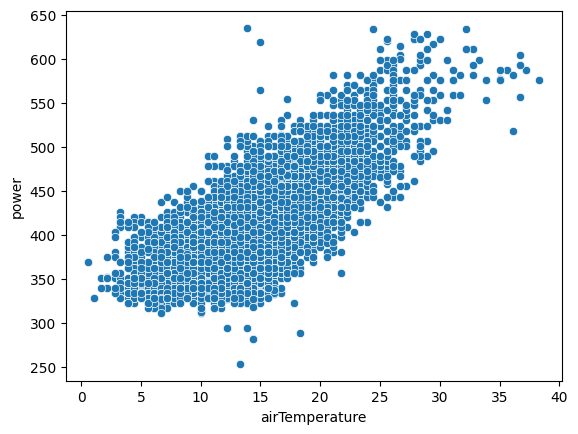

In [206]:
dataResetIndex = data.reset_index()

# Scatter diagram
sns.scatterplot(x="airTemperature", y="power", data=dataResetIndex)
plt.show()

# We can see that the power consumption is higher when the temperature is higher
# This could mean that there is no electrical heating in the building

Text(0.5, 1.0, 'Electrical Load Time Series')

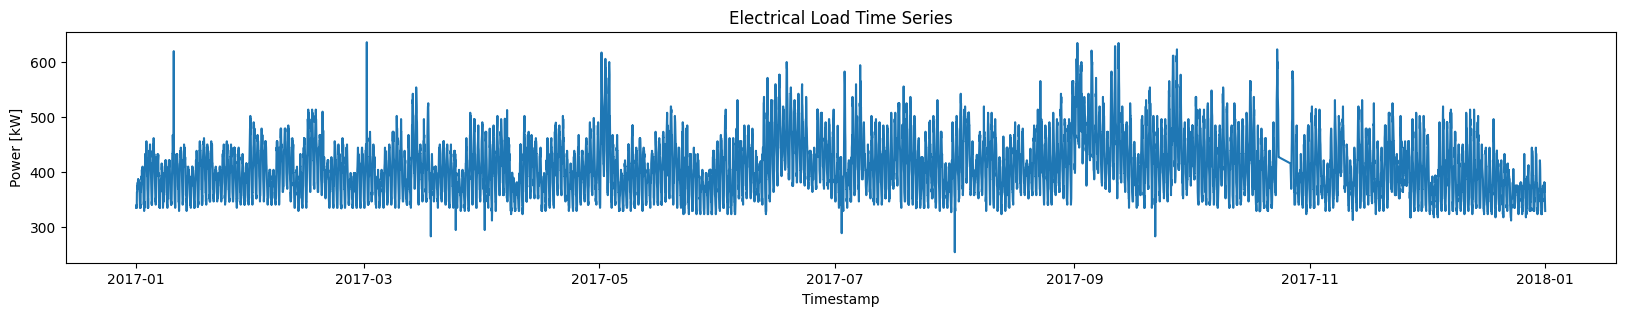

In [207]:
# Plot of "power" versus "timestamp"
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(dataResetIndex["timestamp"], dataResetIndex["power"])
ax.set_xlabel("Timestamp")
ax.set_ylabel("Power [kW]")
ax.set_title("Electrical Load Time Series")

In [208]:
# Skipping the cell:
%%script false --no-raise-error

# Visualize original data subset by month
january = data.loc["2017-01-01 00:00:00":"2017-01-31 23:59:00"].reset_index()
february = data.loc["2017-02-01 00:00:00":"2017-02-28 23:59:00"].reset_index()
march = data.loc["2017-03-01 00:00:00":"2017-03-31 23:59:00"].reset_index()
april = data.loc["2017-04-01 00:00:00":"2017-04-30 23:59:00"].reset_index()
may = data.loc["2017-05-01 00:00:00":"2017-05-31 23:59:00"].reset_index()
june = data.loc["2017-06-01 00:00:00":"2017-06-30 23:59:00"].reset_index()
july = data.loc["2017-07-01 00:00:00":"2017-07-31 23:59:00"].reset_index()
august = data.loc["2017-08-01 00:00:00":"2017-08-31 23:59:00"].reset_index()
september = data.loc["2017-09-01 00:00:00":"2017-09-30 23:59:00"].reset_index()
october = data.loc["2017-10-01 00:00:00":"2017-10-31 23:59:00"].reset_index()

monthWithMissingValues = [march, june, september, october]
montWithNonMissingValues = [january, february, april, may, july, august,]
allMonths = [january, february, march, april, may, june, july, august, september, october ]

for month in allMonths:
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.plot(month['timestamp'], month['power'], label='Original')
    ax.set_title(f'Original Timeseries - {month["timestamp"][0].strftime("%B")}')
    ax.set_ylabel('Power')
    ax.set_xlabel('Time')
    ax.set_ylim([0, None])

UsageError: Line magic function `%%script` not found.


Text(120.72222222222221, 0.5, 'Date')

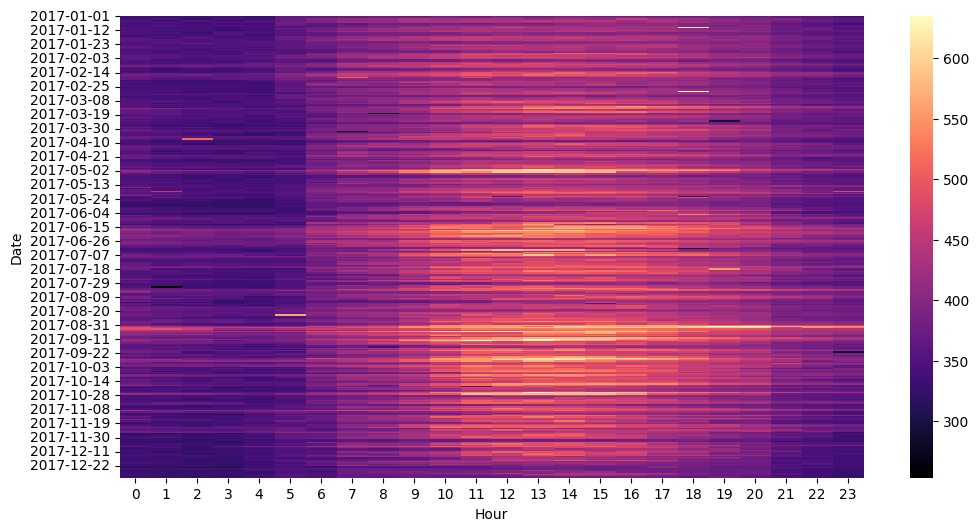

In [209]:
# Heatmap
dataResetIndex['hour'] = dataResetIndex['timestamp'].dt.hour
dataResetIndex['date'] = dataResetIndex['timestamp'].dt.date
df_pivot = dataResetIndex.pivot(index='date', columns='hour', values='power')

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(df_pivot, cmap='magma', ax=ax)

# impostazione delle etichette degli assi
ax.set_xlabel('Hour')
ax.set_ylabel('Date')

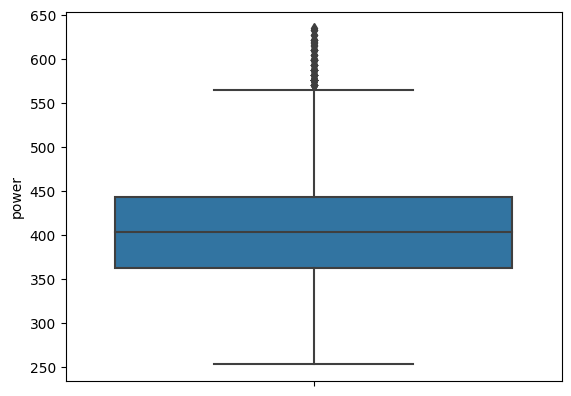

In [210]:
# Boxplot (total)
sns.boxplot(y="power", data=dataResetIndex)
plt.show()

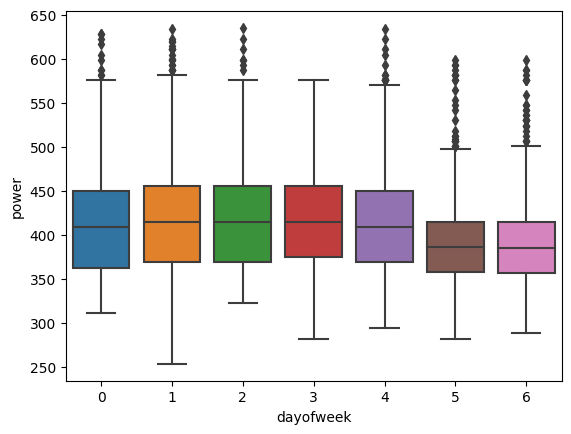

In [211]:
# Power boxplot (day of the week)
dataResetIndex['dayofweek'] = dataResetIndex['timestamp'].dt.day_of_week

sns.boxplot(x='dayofweek', y="power", data=dataResetIndex)
plt.show()

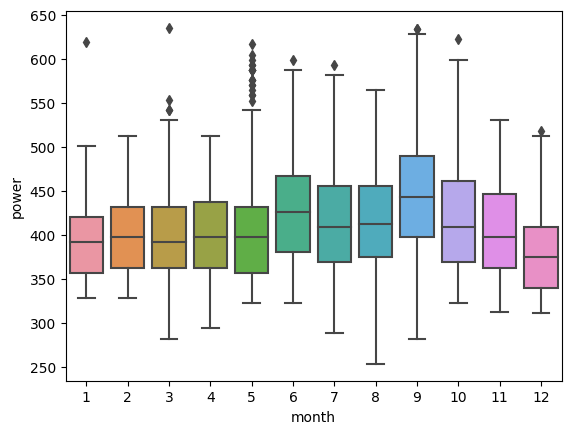

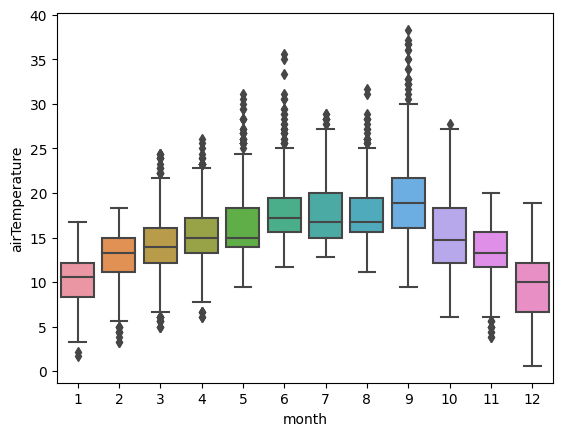

In [212]:
# Power boxplot (month)
dataResetIndex['month'] = dataResetIndex['timestamp'].dt.month

sns.boxplot(x='month', y="power", data=dataResetIndex)
plt.show()

# Temperature boxplot (month)
sns.boxplot(x='month', y="airTemperature", data=dataResetIndex)
plt.show()
    

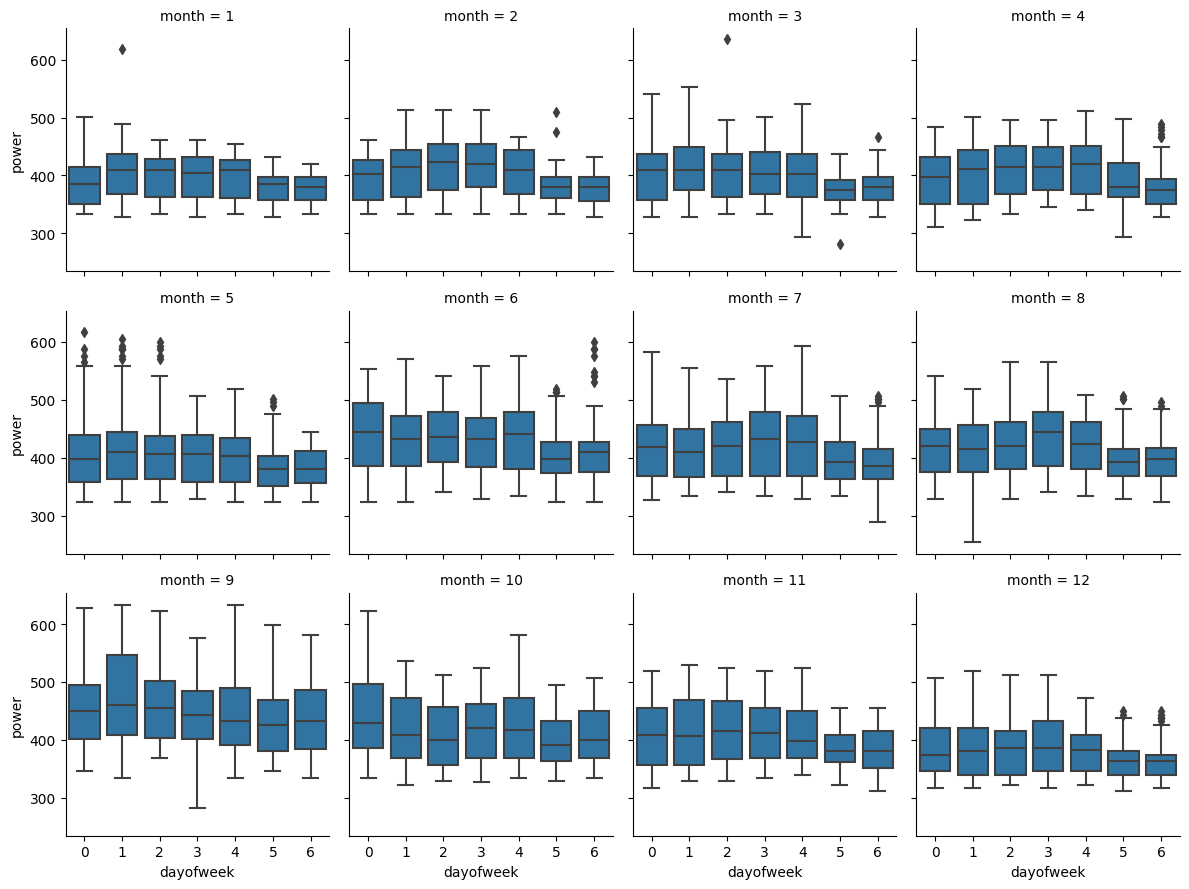

In [213]:
# Power boxplot (day of the week per month)
g = sns.FacetGrid(dataResetIndex, col="month", col_wrap=4)
g.map(sns.boxplot, "dayofweek", "power")
plt.show()

In [214]:
# Skipping the cell:
%%script false --no-raise-error

# Load profile (per month)
dataResetIndex_mean = dataResetIndex.groupby(['month', 'hour'])['power'].mean().reset_index()
g = sns.FacetGrid(data=dataResetIndex, col='month', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

for ax, day in zip(g.axes.flatten(), dataResetIndex_mean['month'].unique()):
    sns.lineplot(x='hour', y='power', data=dataResetIndex_mean[dataResetIndex_mean['month'] == day], color='r', ax=ax, label='Profilo medio', legend=False)

plt.show()

UsageError: Line magic function `%%script` not found.


In [215]:
# Skipping the cell:
%%script false --no-raise-error

# Load profile (per day of the week)
dataResetIndex_mean = dataResetIndex.groupby(['dayofweek', 'hour'])['power'].mean().reset_index()
g = sns.FacetGrid(data=dataResetIndex, col='dayofweek', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

for ax, day in zip(g.axes.flatten(), dataResetIndex_mean['dayofweek'].unique()):
    sns.lineplot(x='hour', y='power', data=dataResetIndex_mean[dataResetIndex_mean['dayofweek'] == day], color='r', ax=ax, label='Profilo medio', legend=False)

plt.show()

UsageError: Line magic function `%%script` not found.


In [216]:
# How is the average load profile?
# It is not representative of all profiles that fall into the same grouping. There is a lot of variability in the groupings: we have profiles ranging from 300 to 600 kW. 

# What analysis could we do to better group the load profiles?
# We can proceed with a clustering analysis of the load profiles.

## Load profiles characterization
Perform on the training dataset a load profile characterization process based on unsupervised clustering algorithms according to the following steps:

**2.1** _Dataset manipulation_: the training dataset should be organized into a MxN matrix to perform clustering according to one of the methods introduced during the course.

In [217]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Add new columns for data and hour
data = data.reset_index()
data['date'] = data['timestamp'].dt.date
data['hour'] = data['timestamp'].dt.hour

# Generate a MxN matrix to perform the clustering
data_matrix = data.pivot(index='date', columns='hour', values='power')

**2.2** _Identification of the “best” clustering solution_: the “best” number of clusters should be identified according to both evaluation metrics (i.e. silhouette index and davies bouldin index) introduced during the course and personal considerations with respect to the results obtained.

In [218]:
# Evaluate the best number of clusters between 2 and 8
K_range = [2, 3, 4, 5, 6, 7, 8]
db_list = []
sh_list = []

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=0).fit(data_matrix)
    labels = kmeans.labels_
    sh_list.append(silhouette_score(data_matrix, kmeans.labels_))
    db_list.append(davies_bouldin_score(data_matrix, kmeans.labels_))
    print(f"Number of cluster: {K} ")
    print(f"Silhouette score: {silhouette_score(data_matrix, kmeans.labels_)}")
    print(f"DB Index: {davies_bouldin_score(data_matrix, kmeans.labels_)}")
    print(np.unique(labels, return_counts=True))
    print()

print(f"The best number of clusters according to Silhouette is {K_range[np.argmax(sh_list)]}")
print(f"The best number of clusters according to DB Index is {K_range[np.argmin(db_list)]}")

# The two indexes give us an indication, but not necessarily the right answer.
# To understand and evaluate the result visualizations can come to our aid.

Number of cluster: 2 
Silhouette score: 0.3635082038988272
DB Index: 1.0081695427814268
(array([0, 1]), array([152, 210], dtype=int64))

Number of cluster: 3 
Silhouette score: 0.33637742986288427
DB Index: 0.9961378951879425
(array([0, 1, 2]), array([ 47, 177, 138], dtype=int64))

Number of cluster: 4 
Silhouette score: 0.24905739738416618
DB Index: 1.2543729811875908
(array([0, 1, 2, 3]), array([ 44, 120,  83, 115], dtype=int64))

Number of cluster: 5 
Silhouette score: 0.23935892916915322
DB Index: 1.299882313098864
(array([0, 1, 2, 3, 4]), array([ 45, 104, 122,  75,  16], dtype=int64))

Number of cluster: 6 
Silhouette score: 0.1892670306873982
DB Index: 1.5916473067622607
(array([0, 1, 2, 3, 4, 5]), array([87, 34, 90, 15, 71, 65], dtype=int64))

Number of cluster: 7 
Silhouette score: 0.18493488131048738
DB Index: 1.4598903051699215
(array([0, 1, 2, 3, 4, 5, 6]), array([ 2, 79, 17, 66, 85, 82, 31], dtype=int64))

Number of cluster: 8 
Silhouette score: 0.21396059978333531
DB Index

**2.3** _Data visualization and comment_: visualizations describing the solution obtained should be produced with a critical comment of the results

In [219]:
# Skipping the cell:
%%script false --no-raise-error

# Perform clustering for different K
K_range = [2, 3, 4, 5]

for K in K_range:
    
    print(f"Number of clusters: {K} ")
    print()

    df_matrix = data_matrix
    df = data

    kmeans = KMeans(n_clusters=K, random_state=0).fit(df_matrix)
    labels = kmeans.labels_
    cluster_counts = np.unique(labels, return_counts=True)
    
    df['cluster'] = np.repeat(labels, 24)
    
    # Average load profile
    centroids = df.groupby(['cluster', 'hour'])['power'].mean().reset_index()
    g = sns.FacetGrid(data=df, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
    g.map(sns.lineplot, 'hour', 'power', color='gray')
    i = 0
    for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
        sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, legend=False)
        ax.set_ylim(bottom=0, top=df['power'].max())
        ax.set_xticks(range(0, 24))
        ax.grid(True, linestyle='--')
        cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
        ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
        i += 1
    plt.show()

    # Calendar visualization
    cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(df_matrix.index))
    colors = sns.color_palette("husl", K)
    hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in colors]
    cmap = ListedColormap(hex_colors)

    fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap, 
                                fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3, daylabels='MTWTFSS')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K-1))
    sm.set_array([])
    cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cb.set_label('Cluster')
    cb.set_ticks(cal_data['cluster'].unique())
    cb.set_ticklabels(cal_data['cluster'].unique())

    plt.show()


UsageError: Line magic function `%%script` not found.


In [220]:
from scipy.cluster.hierarchy import dendrogram

# Hierarchical clustering dendrogram
df_matrix = data_matrix
df = data

# Function that create linkage matrix and plot the dendrogram
def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

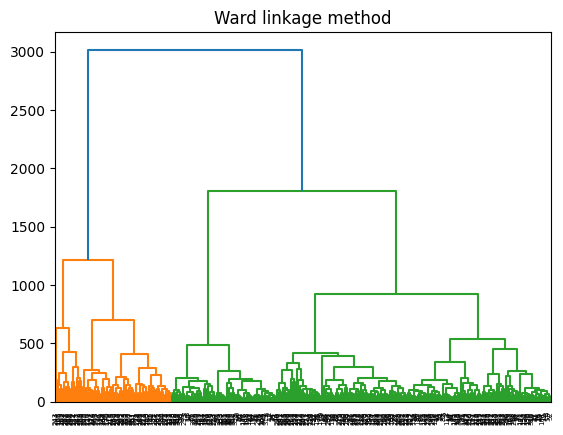

In [221]:
from sklearn.cluster import AgglomerativeClustering

# Ward linkage method (print top 'p' levels)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="ward").fit(df_matrix)

plt.title("Ward linkage method")
plot_dendrogram(model, truncate_mode="level", p=0)
plt.show()

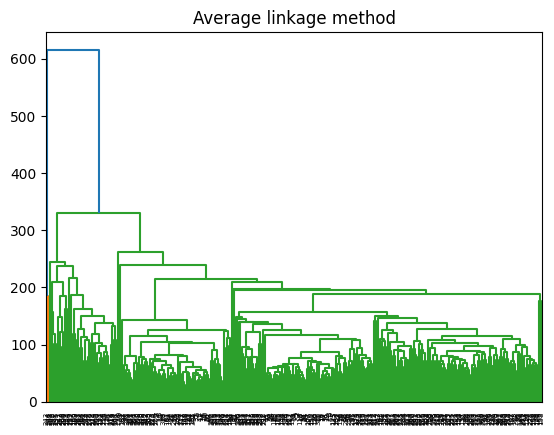

In [222]:
# Average linkage method (print top 'p' levels)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="average").fit(df_matrix)

plt.title("Average linkage method")
plot_dendrogram(model, truncate_mode="level", p=0)
plt.show()

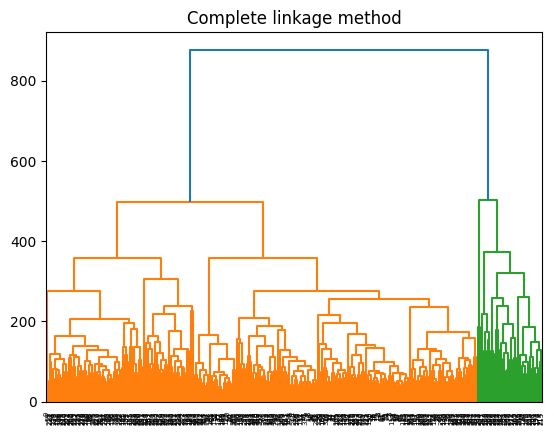

In [223]:
# Complete linkage method (print top 'p' levels)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete").fit(df_matrix)

plt.title("Complete linkage method")
plot_dendrogram(model, truncate_mode="level", p=0)
plt.show()

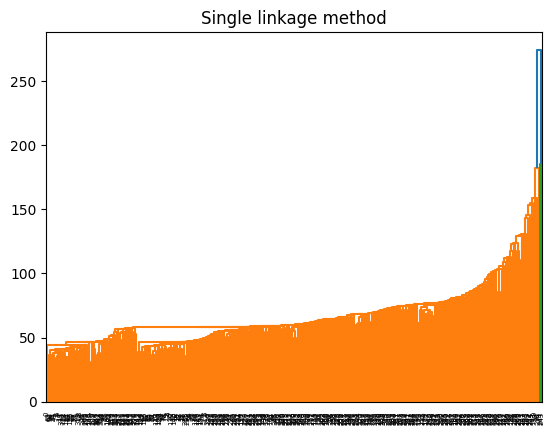

In [224]:
# Single linkage method (print top 'p' levels)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="single").fit(df_matrix)

plt.title("Single linkage method")
plot_dendrogram(model, truncate_mode="level", p=0)
plt.show()

Text(0.5, 1.0, 'SH Index')

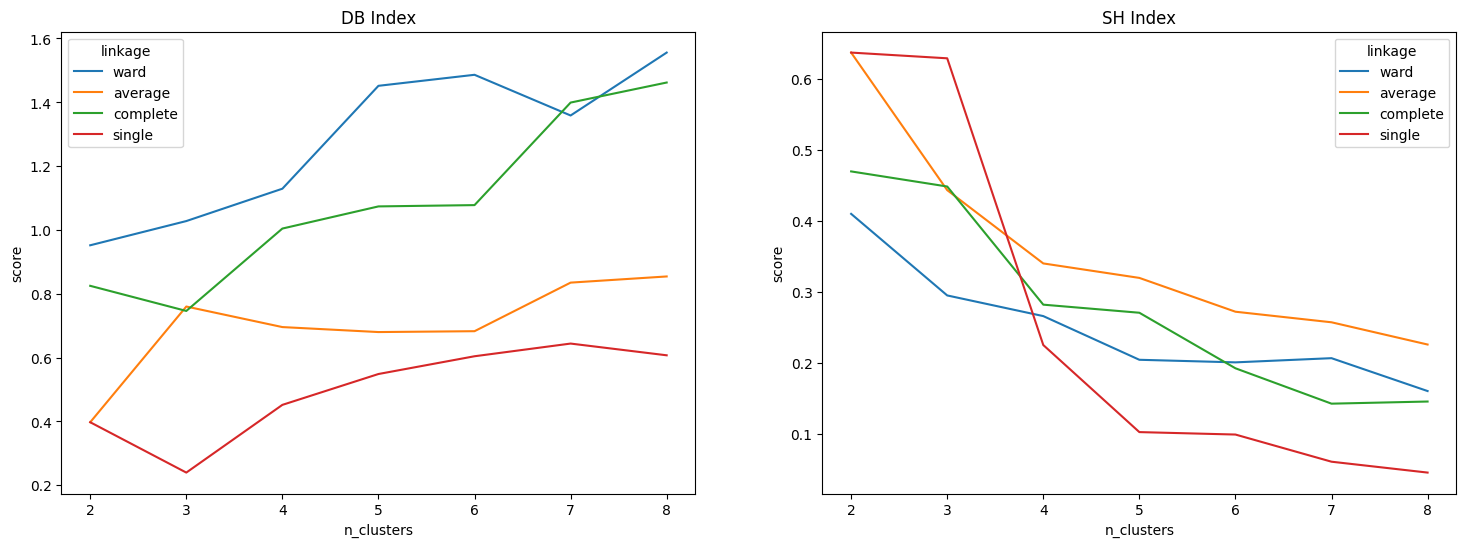

In [225]:
# Grid search for hyperparameter tuning
from sklearn.model_selection import ParameterGrid

params = {
    "n_clusters": [2, 3, 4, 5, 6, 7, 8],
    "linkage": ["ward", "average", "complete", "single"]
}

db_df = []
sh_df = []

for config in ParameterGrid(params):
    model = AgglomerativeClustering(**config)
    model.fit(df_matrix)
    db_df.append({
        'linkage': config['linkage'],
        'n_clusters': config['n_clusters'],
        'score': davies_bouldin_score(df_matrix, model.labels_)
    })
    sh_df.append({
        'linkage': config['linkage'],
        'n_clusters': config['n_clusters'],
        'score': silhouette_score(df_matrix, model.labels_)
    })

db_df = pd.DataFrame(db_df)
sh_df = pd.DataFrame(sh_df)

# Plot the DB and SH indices as lineplots in function of the number
# of clusters and for each linkage method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
sns.lineplot(ax=ax1, x="n_clusters", y="score", hue="linkage", data = db_df)
ax1.set_title("DB Index")

sns.lineplot(ax=ax2, x="n_clusters", y="score", hue="linkage", data = sh_df)
ax2.set_title("SH Index")

In [226]:
# Skipping the cell:
%%script false --no-raise-error

# Analyze different linkage methods and number of K

K_range = [2, 3, 4, 5]
linkage_methods = ["ward", "average", "complete", "single"]

for linkage_method in linkage_methods:
    for K in K_range:
        
        print(f"Hierarchical clustering")
        print(f"Method: {linkage_method}")
        print(f"Number of clusters: {K} ")
        print()

        df_matrix = data_matrix
        df = data

        model = AgglomerativeClustering(distance_threshold=None, n_clusters=K, linkage=linkage_method).fit(df_matrix)
        labels = model.labels_

        cluster_counts = np.unique(labels, return_counts=True)

        # Add the cluster labels to the original dataset
        df['cluster'] = np.repeat(labels, 24)

        # creating a new DataFrame with the average power for each hour of the day and for each cluster
        centroids = df.groupby(['cluster', 'hour'])['power'].mean().reset_index()

        # generating load profiles
        g = sns.FacetGrid(data=df, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
        g.map(sns.lineplot, 'hour', 'power', color='gray')

        # adding average values
        i = 0
        for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
            sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, label='Profilo medio', legend=False)
            ax.set_ylim(bottom=0, top=df['power'].max())
            ax.set_xticks(range(0, 24))
            ax.grid(True, linestyle='--')
            
            cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
            ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
            i += 1

        plt.show()

        # calendar visualization
        cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(df_matrix.index))
        colors = sns.color_palette("husl", K)
        hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in colors]
        cmap = ListedColormap(hex_colors)

        fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap, 
                                    fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3, daylabels='MTWTFSS')

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K-1))
        sm.set_array([])
        cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
        cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
        cb.set_label('Cluster')
        cb.set_ticks(cal_data['cluster'].unique())
        cb.set_ticklabels(cal_data['cluster'].unique())

        plt.show()

UsageError: Line magic function `%%script` not found.


#### Energy benchmarking model
Develop a regression model to perform a benchmarking process of energy consumption according to the following steps:

**3.1** _Input data selection_: according to the results of the load profile characterization phase the training set CAN be filtered removing records relative to load profiles representing infrequent or anomalous consumption patterns

In [227]:
# Important notes before starting the analysis:

# To build a benchmark model, it is important to provide as an INPUT A DATASET THAT IS THE
# MOST CLEAN AND REPRESENTATIVE OF NORMAL SYSTEM OPERATING CONDITIONS.
# The clustering analysis we performed could be useful for this purpose, for example, to do
# an initial filtering of our training dataset.

# Example: we need to apply our model to winter months, November and December.
# We first perform a load profile characterization analysis on our training dataset.
# We discover that our system has two different consumption patterns for summer and winter days.
# Nothing prohibits us from deciding that, since we have to do the test only on the winter months, 
# we train our model only on the data belonging to the profiles
# we were able to identify as those representative of winter operation.

# Therefore, we choose the benchamrk based on the characteristics
# of the portion of the dataset we want to test.

In [228]:
# Feature engineering
# Modify dataset structure for future analyses
data = data.set_index('timestamp')
data.drop("date", axis=1, inplace=True)
data["day_of_week"] = data.index.dayofweek

In [229]:
# TODO: Filter the data according to the previous analyses
# We need to delete all the "anomalies" (example: small clusters with few data points)



# Split dataset between train and test
train = data.loc["2017-01-01 00:00:00":"2017-10-31 23:59:00"]
test = data.loc["2017-11-01 00:00:00":"2017-12-31 23:59:00"]

# Split between X=features (independent variables) and y=target variable (dependent variable)
X_train = train.drop("power", axis=1)
y_train = train["power"]
X_test = test.drop("power", axis=1)
y_test = test["power"]

**3.2** _Model training and selection_: a regression model based on one of the methods available in the scikit-library should be trained. Different methods of the scikit library can be tested (https://scikit-learn.org/stable/supervised_learning.html). If reputed necessary, hyperparameter tuning should be performed employing cross validation as introduced during the course

In [230]:
# Given the boundary conditions, what should be the expected consumption from my system
# considering what has happened in the past (train)?

# TODO: replace the following with other models from scikit-learn
model = RandomForestRegressor() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

**3.3** _Performance evaluation_: the performance of the model should be evaluated using appropriate metrics, such as mean absolute error, and root mean square error

In [231]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

# MAPE = Mean Absolute Percentage Error
# Measeure of how much the estimated value differs from
# the actual value (0-100%) 
# < 10 % = Very good
# 10 % - 20 % = Good
# 20 % - 50 % = OK
# > 50 % = Very bad

# RMSE = Root Mean Squared Error
# It measures the average difference between values predicted
# by a model and the actual values. It provides an estimation of
# how well the model is able to predict the target value (accuracy).
# The closer RMSE is to 0, the more accurate the model is. 
# See: https://stephenallwright.com/good-rmse-value/

MAPE: 5.09%
MAE: 20.30
MSE: 648.55
RMSE: 25.47


**3.3** _Model deployment_: the trained (and validated) model should be, applied to the testing dataset to estimate the energy consumption. The estimated energy consumption should be compared with the actual energy consumption to evaluate overconsumption and underconsumption as introduced during the course

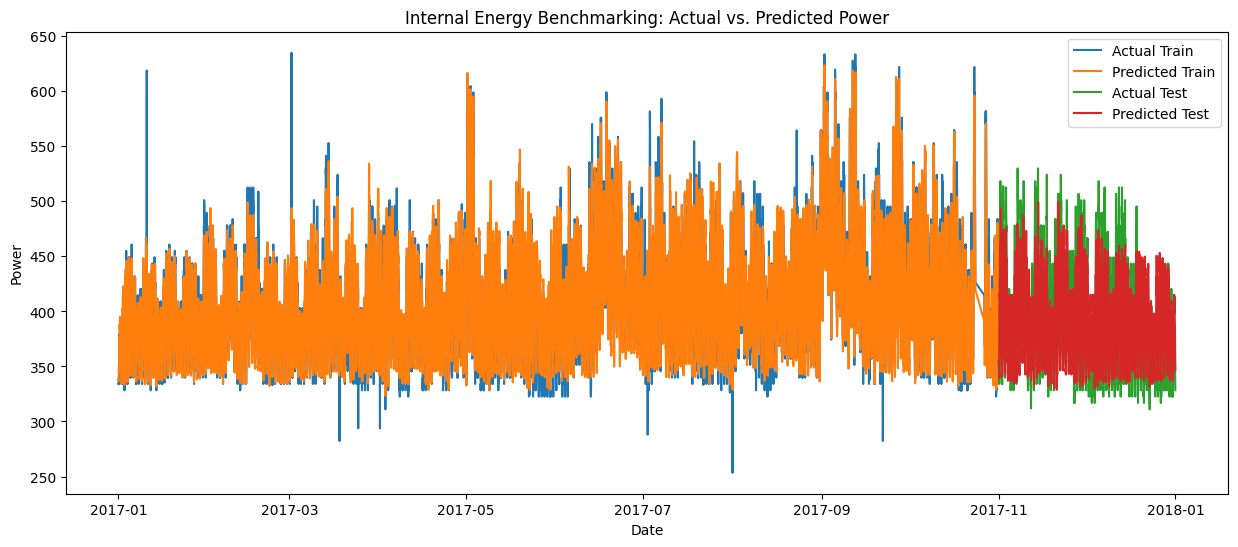

In [232]:
# Line plot with predictions and real values for both training and testing
y_train_pred = model.predict(X_train)

plt.figure(figsize=(15, 6))
plt.plot(train.index, y_train, label="Actual Train")
plt.plot(train.index, y_train_pred, label="Predicted Train")
plt.plot(test.index, y_test, label="Actual Test")
plt.plot(test.index, y_pred, label="Predicted Test")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("Internal Energy Benchmarking: Actual vs. Predicted Power")
plt.legend()
plt.show()

# TODO: Are our features enough for the prediction? Should we consider more feature?
# How can we describe the result?

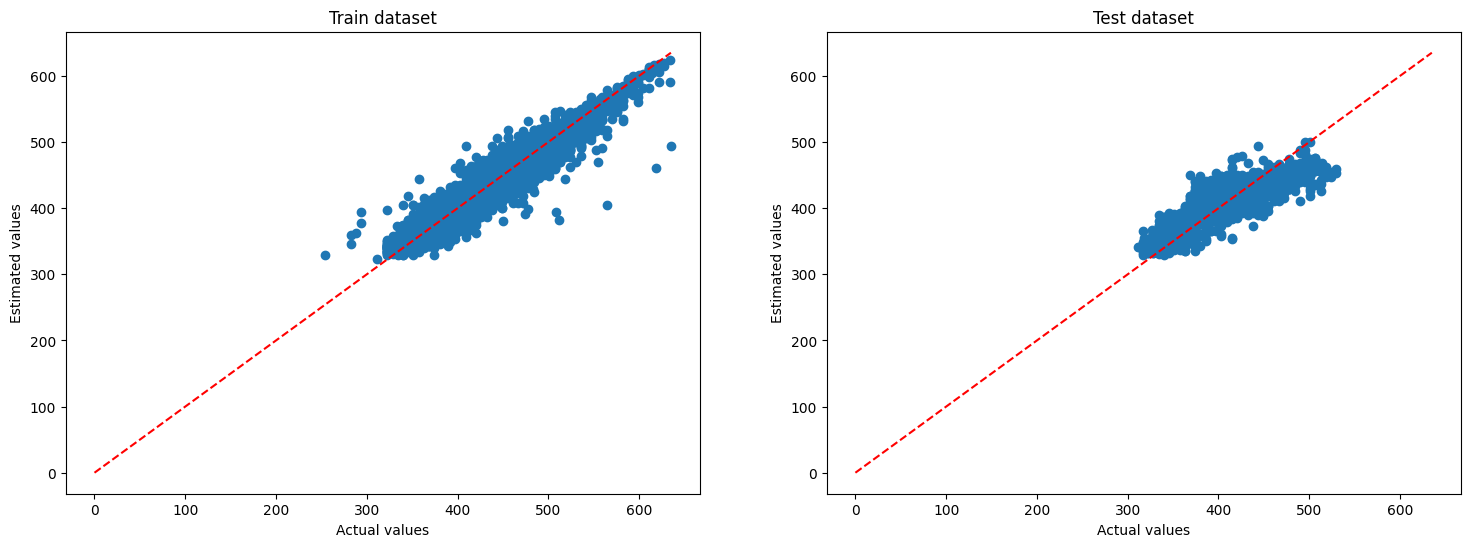

In [233]:
# Scatter diagram that shows the relationship between the actual and predicted values.
# In the ideal case, the point should be on the bisector (red line).

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

# Train dataset
ax1.scatter(y_train, y_train_pred)
ax1.set_title("Train dataset")
ax1.set_xlabel("Actual values")
ax1.set_ylabel("Estimated values")
ax1.plot([0, data.power.max()], [0, data.power.max()], linestyle='--', color='red')

# Test dataset
ax2.scatter(y_test, y_pred)
ax2.set_title("Test dataset")
ax2.set_xlabel("Actual values")
ax2.set_ylabel("Estimated values")
ax2.plot([0, data.power.max()], [0, data.power.max()], linestyle='--', color='red')

# On the traing dataset we have a more squashed situation on the bisector, which is what we expect.
# On the testing phase the situation is relatively worse.
# We need to understand the reason, which can be different:
# 1) Our model has been trained insufficiently correctly
# 2) We are missing important inputs for the prediction
# 3) There has been a divergence of consumption from the benchamrking condition.
# For answering to this question, we can make subjective and quantitative evaluations.
# We can try different model strategies to check if changing the model
# also changes the prediction.

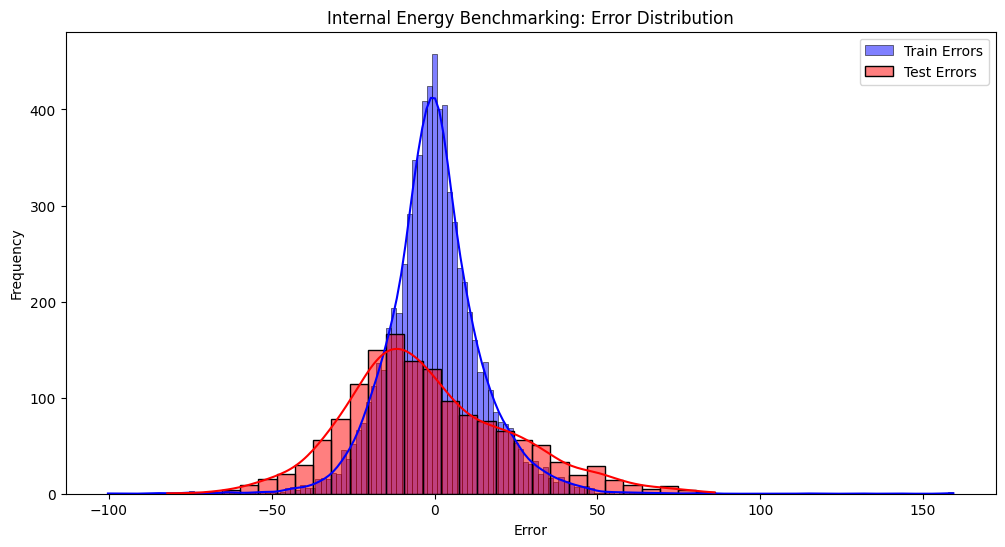

In [234]:
# Plot with the errors distribution for both training and testing
# Error = actual value - predicted value

train_errors = y_train - y_train_pred
test_errors = y_test - y_pred

plt.figure(figsize=(12, 6))
sns.histplot(train_errors, kde=True, color="blue", label="Train Errors")
sns.histplot(test_errors, kde=True, color="red", label="Test Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Internal Energy Benchmarking: Error Distribution")
plt.legend()
plt.show()

# How should the error be distributed?
# It should be NORMALLY distributed, that is, it must have
# a MEAN OF ZERO and a "BELL-SHAPED" DISTRIBUTION.
# If we assume that we have given all the necessary information to the model
# to estimate the phenomenon, we expect that the DISTRIBUTION IS AT LEAST NORMAL

# If we had given, for example, only the day of the week as a predictor, the distribution
# would not be normal. It would have had some peaks because the model was not trained properly
# since the predictors are not predictive enough for the phenomenon we are analyzing.

# In our case, the mean of the errors is not close to zero for the test
# dataset, which probably means that we are missing some predictors.

**3.4** _Data visualization and comment_: visualizations describing the solution obtained should be produced with a critical comment of the results

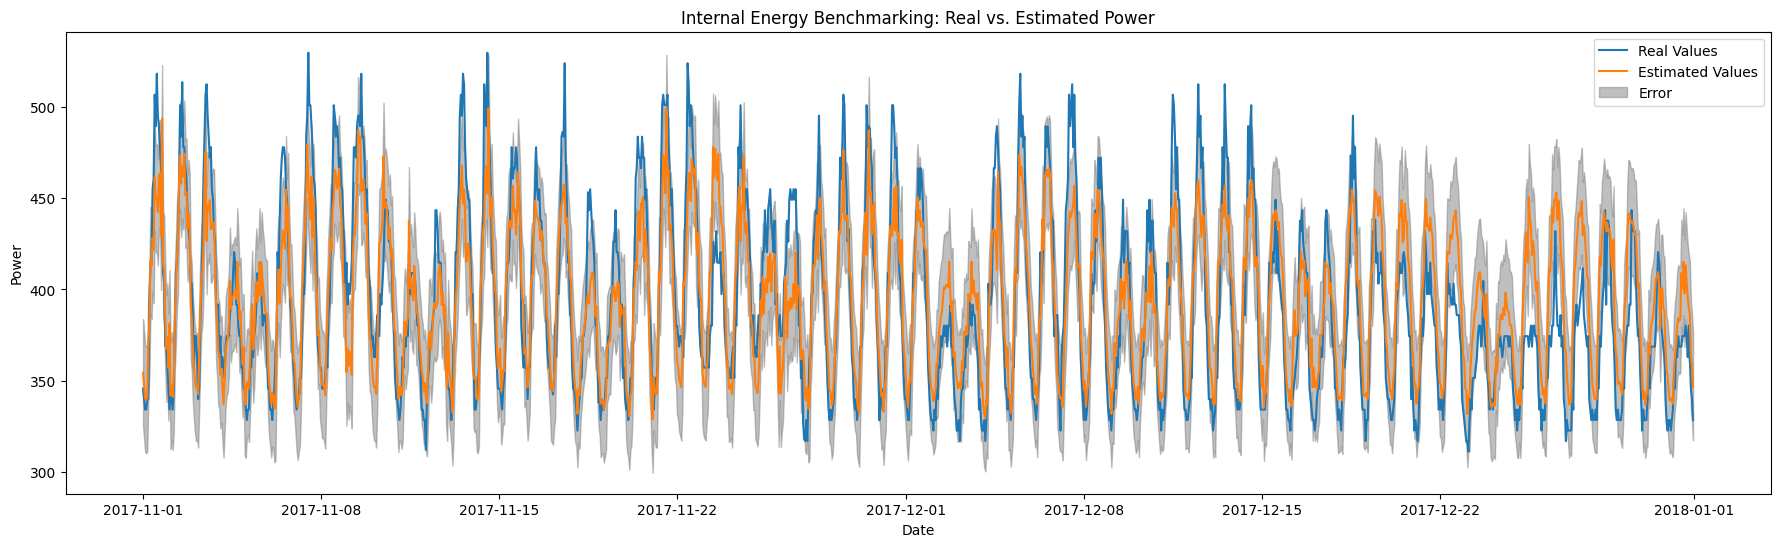

In [235]:
import scipy.stats as stats

# We have trained the model on the training dataset and now we want to make EVALUATIONS.
# This means that we want to understand how much the recorded consumption deviates from
# what is the estimate that we predicted with our model.

# We want to consider a range in which we have a 95% probability
# that our estimate falls within that range.

# We will evaluate two quantities: overconsumption and underconsumption,
# considering the actual values that do not fall within the confidence interval.
# Why do we use the confidence interval and not directly the value estimated by the model?
# Because calculating the difference using only the model-estimated value would be misleading.
# There is uncertainty in our predictions and we have to take this into account.

def prediction_intervals(y_true_train, y_pred_train, y_pred_test, alpha=0.95):
    errors = y_true_train - y_pred_train
    std_errors = np.std(errors)
    z_score = stats.norm.ppf(1 - (1 - alpha) / 2)
    
    lower_bounds = y_pred_test - z_score * std_errors
    upper_bounds = y_pred_test + z_score * std_errors
    
    return lower_bounds, upper_bounds

lower_bounds, upper_bounds = prediction_intervals(y_train, y_train_pred, y_pred)

# ONLY for the test dataset:
# We plot predicted value, the actual value and the confidence interval
# of the prediction (grey band).
plt.figure(figsize=(22, 6))
plt.plot(test.index, y_test, label="Real Values")
plt.plot(test.index, y_pred, label="Estimated Values")
plt.fill_between(test.index, lower_bounds, upper_bounds, color="gray", alpha=0.5, label="Error")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("Internal Energy Benchmarking: Real vs. Estimated Power")
plt.legend()
plt.show()

# We can see that sometimes our actual consumption exceeds the confidence interval.

In [236]:
# Let's evaluate the underconsumption and the overconsumption
# with respect to the estimated values (benchmarking) that our
# model predicted.

# Underconsumption
# Let's evaluate the underconsumption as the lower_bounds of the
# confidence interval minus the power actually recorded in the test dataset

# We will use 2 metrics:
# 1) Total underconsumption in kWh
# 2) Percentage of underconsumption over the total consumption

test['underconsumption'] = lower_bounds - test['power']
test['underconsumption'] = test['underconsumption'].clip(lower=0)
total_underconsumption = np.round(test['underconsumption'].sum(), 1)
total_consumption = np.round(test['power'].sum(), 1)
underconsumption_percentage = np.round(total_underconsumption/total_consumption*100, 2)
print(f'Total underconsumption identified: {total_underconsumption} kWh')
print(f'Percentage of underconsumption over total: {underconsumption_percentage} %')
print()

# Overconsumption
test['overconsumption'] = test['power'] - upper_bounds
test['overconsumption'] = test['overconsumption'].clip(lower=0)
total_overconsumption = np.round(test['overconsumption'].sum(), 1)
overconsumtion_percentage = np.round(total_overconsumption/total_consumption*100, 2)
print(f'Total underconsumption identified: {total_overconsumption} kWh')
print(f'Percentage of underconsumption over total: {overconsumtion_percentage} %')

Total underconsumption identified: 1778.8 kWh
Percentage of underconsumption over total: 0.31 %

Total underconsumption identified: 2803.1 kWh
Percentage of underconsumption over total: 0.49 %


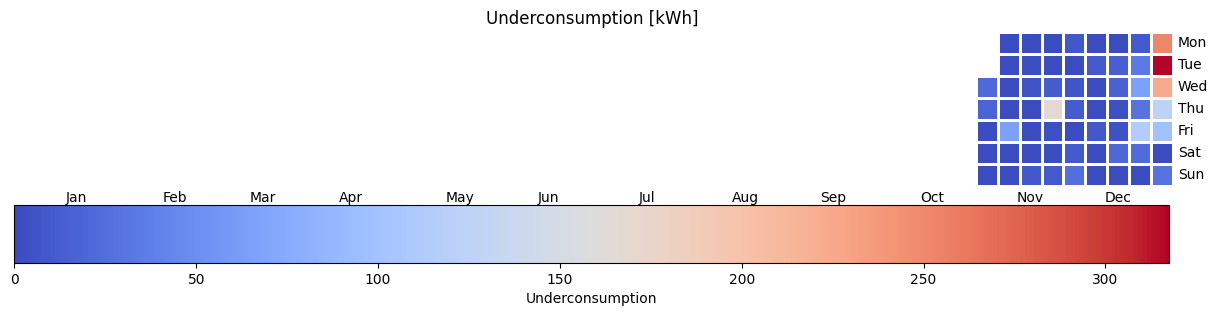

In [237]:
# Calendarmap with underconsumption (test dataset only)

import calmap
import matplotlib as mpl

test['date'] = test.index.date
underconsumption_day = test.groupby('date')['underconsumption'].sum().reset_index()
underconsumption_day['date'] = pd.to_datetime(underconsumption_day['date'])
underconsumption_day = underconsumption_day.set_index('date')

plt.figure(figsize=(15, 5))
calmap.yearplot(underconsumption_day['underconsumption'], year=2017, cmap='coolwarm', fillcolor='white')
plt.title("Underconsumption [kWh]")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=underconsumption_day['underconsumption'].min(), vmax=underconsumption_day['underconsumption'].max())
cax = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', pad=0.05)
cax.set_label("Underconsumption")
plt.show()

# We can see thath much of the underconsumption occurs in December.
# We can  think that, in this case, it is not a problem of the model.
# It is, instead, an ANOMALOUS CONSUMPTION of the system that can be justified 
# by the knowledge that the last days of December are holidays and therefore it
# is expected that the system will not be used at full capacity.

# When there are anomalous underconsumption that cannot be easily explained, the justification 
# could be a malfunction or abnormal management of the energy system or a problem of the model.

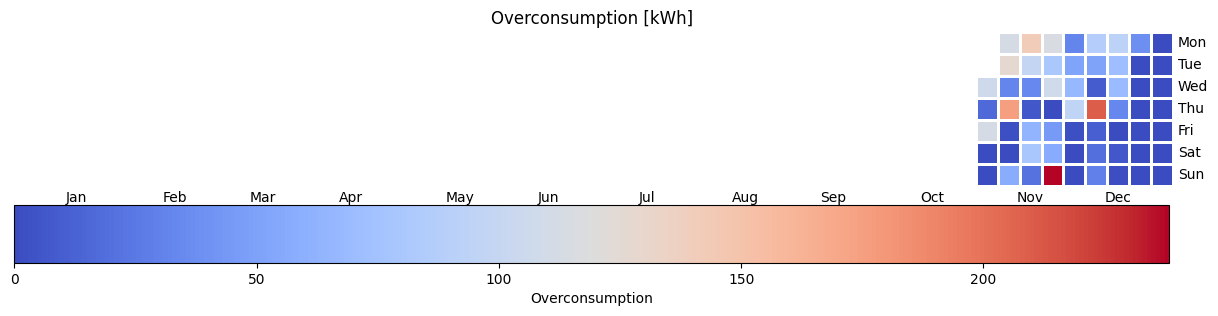

In [238]:
# Calendarmap with overconsumption (test dataset only)
overconsumption_day = test.groupby('date')['overconsumption'].sum().reset_index()
overconsumption_day['date'] = pd.to_datetime(overconsumption_day['date'])
overconsumption_day = overconsumption_day.set_index('date')

plt.figure(figsize=(15, 5))
calmap.yearplot(overconsumption_day['overconsumption'], year=2017, cmap='coolwarm', fillcolor='white')
plt.title("Overconsumption [kWh]")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=overconsumption_day['overconsumption'].min(), vmax=overconsumption_day['overconsumption'].max())
cax = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', pad=0.05)
cax.set_label("Overconsumption")
plt.show()

# We can see that there is a day in november when there is an important
# overconsumption: it is November the 26.
# Let's analyze this day better in the next cells.

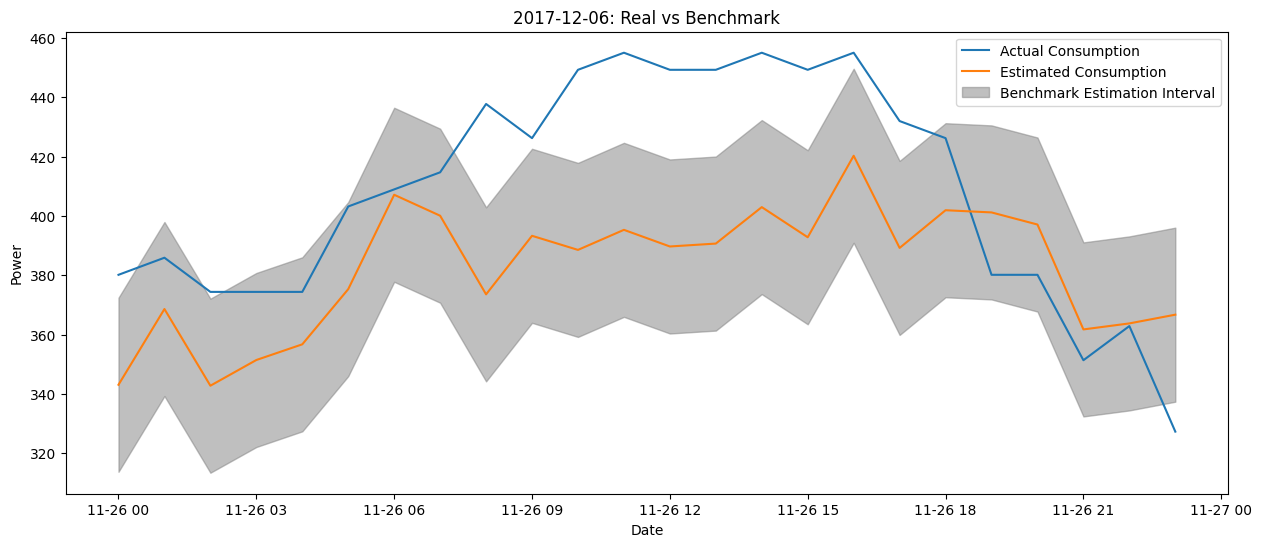

In [239]:
# Let's analyze a day when consumption is not in line with what the model predicts
test['lower_bounds'] = lower_bounds
test['upper_bounds'] = upper_bounds
test['power_pred'] = y_pred

# 2017-11-26
test_subset = test["2017-11-26"]

plt.figure(figsize=(15, 6))
plt.plot(test_subset.index, test_subset.power, label="Actual Consumption")
plt.plot(test_subset.index, test_subset.power_pred, label="Estimated Consumption")
plt.fill_between(test_subset.index, test_subset.lower_bounds, test_subset.upper_bounds, color="gray", alpha=0.5, 
                 label="Benchmark Estimation Interval")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("2017-12-06: Real vs Benchmark")
plt.legend()
plt.show()

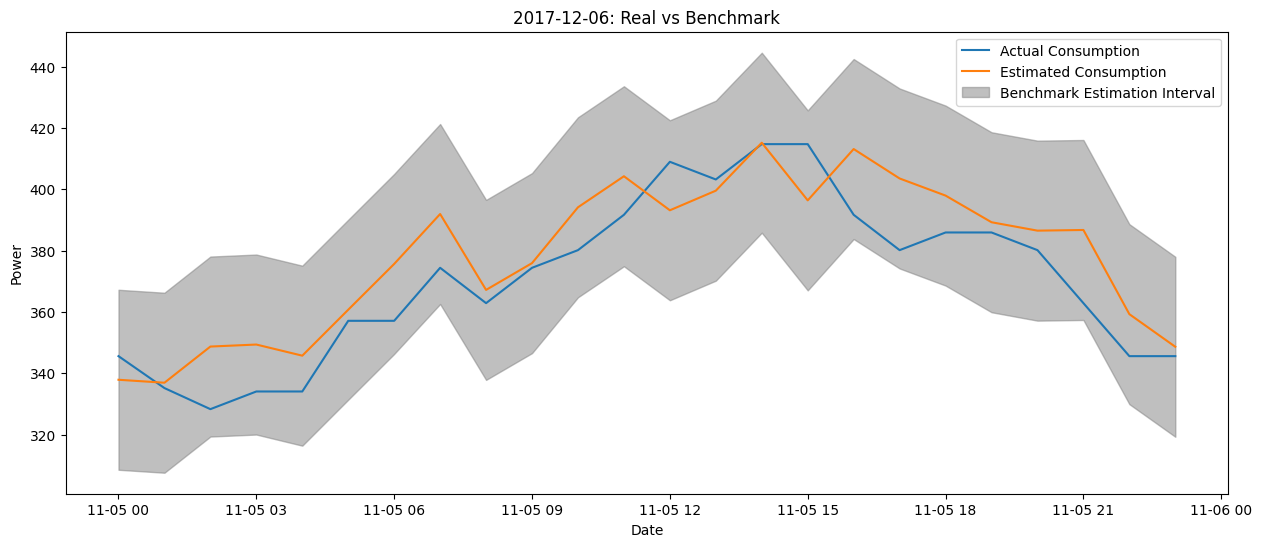

In [240]:
# Let's analyze a day when consumption is in line with what the model predicts

# 2017-11-05
test_subset = test["2017-11-05"]

plt.figure(figsize=(15, 6))
plt.plot(test_subset.index, test_subset.power, label="Actual Consumption")
plt.plot(test_subset.index, test_subset.power_pred, label="Estimated Consumption")
plt.fill_between(test_subset.index, test_subset.lower_bounds, test_subset.upper_bounds, color="gray", alpha=0.5, 
                 label="Benchmark Estimation Interval")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("2017-12-06: Real vs Benchmark")
plt.legend()
plt.show()